<a href="https://colab.research.google.com/github/FrederikWarburg/CS-294-131-Trustworthy-Deep-Learning/blob/master/dissect_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+git://github.com/davidbau/quick-netdissect.git#egg=netdissect

  Cloning git://github.com/davidbau/quick-netdissect.git to /tmp/pip-install-fq4hn8gl/netdissect
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5v5u7h6/wheels/95/03/aa/c38949a7269a6ee2f0ceb9e98b54e67fc7f9bfc5b47d1c5e4f
Successfully built netdissect


In [3]:
import torch
torch.__version__

'1.0.1.post2'

In [1]:
!pip install torch

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import sys
import os

sys.path.append(os.getcwd() + "/wgan-gp/")
sys.path.append(os.getcwd() + "/quick-netdissect/")
sys.path

['',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python35.zip',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/plat-darwin',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/lib-dynload',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/site-packages',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/site-packages/torchvision-0.2.1-py3.5.egg',
 '/Users/frederikwarburg/anaconda3/envs/pyspark/lib/python3.5/site-packages/IPython/extensions',
 '/Users/frederikwarburg/.ipython',
 '/Users/frederikwarburg/Desktop/Berkeley/courses/deeplearning/project/CS-294-131-Trustworthy-Deep-Learning/wgan-gp/',
 '/Users/frederikwarburg/Desktop/Berkeley/courses/deeplearning/project/CS-294-131-Trustworthy-Deep-Learning/quick-netdissect/']

In [3]:

generator = torch.load("wgan-gp/mnist_models/gen_mnist_model_epoch_200.pt", map_location='cpu')
print(generator)
# generater.load_state_dict(torch.load(".sample_data/gen_mnist_model_epoch_200.pt", map_location='cpu'))
# generater.eval()


Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)


In [25]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import h5py

from torchvision.datasets.folder import default_loader

def get_multi_mnist_dataloaders(batch_size=128):
    # Resize images so they are a power of 2
    all_transforms = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.Resize(32),
        transforms.Resize(100),
        transforms.ToTensor()
    ])

    train_data = MultiMNIST('data/multi_mnist/MNIST_synthetic_31_3.h5',  train = True, transform = all_transforms)
    test_data = MultiMNIST('data/multi_mnist/MNIST_synthetic_31_3.h5', train = False, transform = all_transforms)

    # Create dataloaders
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=16)
#     test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16)
#     return train_loader, test_loader
    return train_data, test_data

class MultiMNIST(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path = 'data/multi_mnist/MNIST_synthetic_31_3.h5', train = True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(MultiMNIST, self).__init__()
        
        #['color', 'object', 'part', 'material', 'scene', 'texture']
        self.categories = ['digit']
        
        """
        self.category_info = OrderedDict([('digit',
              {'count': '10',
               'first': '1',
               'frequency': '50000',
               'last': '10',
               'name': 'digit'})])
        self.category_label = {'digit': [{'code': 0,
                                           'coverage': 0.0,
                                           'frequency': 0,
                                           'name': '',
                                           'number': 0},
                                          {'code': 1,
                                           'coverage': 11135.3204744,
                                           'frequency': 62358,
                                           'name': 'one',
                                           'number': 1},
                                          {'code': 2,
                                           'coverage': 12712.8431287,
                                           'frequency': 62310,
                                           'name': 'two',
                                           'number': 2},
                                          {'code': 3,
                                           'coverage': 5778.03820407,
                                           'frequency': 62054,
                                           'name': 'three',
                                           'number': 3},
                                          {'code': 4,
                                           'coverage': 14549.6524542,
                                           'frequency': 61583,
                                           'name': 'four',
                                           'number': 4},
                                          {'code': 5,
                                           'coverage': 5049.98973538,
                                           'frequency': 61508,
                                           'name': 'five',
                                           'number': 5},
                                          {'code': 6,
                                           'coverage': 1478.51858238,
                                           'frequency': 60755,
                                           'name': 'six',
                                           'number': 6},
                                          {'code': 7,
                                           'coverage': 865.041518839,
                                           'frequency': 59516,
                                           'name': 'seven',
                                           'number': 7},
                                          {'code': 8,
                                           'coverage': 4899.17412108,
                                           'frequency': 57825,
                                           'name': 'eight',
                                           'number': 8},
                                          {'code': 9,
                                           'coverage': 2730.58728273,
                                           'frequency': 57560,
                                           'name': 'nine',
                                           'number': 9},
                                          {'code': 10,
                                           'coverage': 1678.05972937,
                                           'frequency': 55938,
                                           'name': 'zero',
                                           'number': 10}]}
        """
        #self.category_map = {'color': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int16)}
        self.directory = 'data/multiMnist/'
        self.image = self.images()
        self.include_bincount = True
        self.label_category = np.zeros(50000)
        self.label_info = None
        self.labels = self.labels()
        self.loader = default_loader
        self.max_segment_depth = 1
        self.num_labels = 10*10*10
        self.resdir = 'data/multiMnist/'
        self.resolution = 64
        self.transform_image = transform
        self.transform_segment = transform
        
    def labels(self):
        labels = []
        for i in range(10):
            for j in range(10):
                for k in range(10):
                    label = str([i,j,k])
                    labels.append(label)
                    
        return labels
    
    def images(self):
        images = []
        for i in range(50000):
            n = str(i)
            filename = n.zfill(6) +'.png'
            
            dict_ = {}
            dict_['digit'] = [filename]
            dict_['ih'] = 64
            dict_['image'] = filename
            dict_['iw'] = 64
            dict_['sh'] = 32
            dict_['sw'] = 32
            
            images.append(dict_)
            
        return images
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):#, seg=False):
        
        n = str(index)
        filename = n.zfill(6) +'.png'
                        
        img = Image.open('data/multiMnist/images/'+filename)
        file = open('data/multiMnist/label/' + filename.replace('png','txt'), 'r')
        target = file.read() 
        file.close()
        target = torch.as_tensor(np.array([int(target[1]), int(target[3]), int(target[5])]), dtype=torch.int32)
        seg = Image.open('data/multiMnist/seg/'+filename)
        
        if self.transform_image:
            print(np.shape(img),np.min(img),np.max(img),type(img))
            print(np.shape(seg), np.min(seg),np.max(seg), type(seg))
            img = self.transform_image(img)
            seg = self.transform_image(seg)

        seg = torch.as_tensor(seg,dtype=torch.int64)    
            
        return (img, seg, target)

In [2]:
import sys
import os

sys.path.append(os.getcwd() + "/wgan-gp/")
sys.path.append(os.getcwd() + "/quick-netdissect/")
sys.path

import torch

from netdissect import retain_layers, dissect
from netdissect import ReverseNormalize
import torchvision.models as models
from netdissect import BrodenDataset
from netdissect.progress import verbose_progress
verbose_progress(True)
from torchvision.models import alexnet
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def eval_constructor(term, construct_types=True):
    '''
    Used to evaluate an arbitrary command-line constructor specifying
    a class, with automatic import of global module names.
    '''
    from collections import defaultdict
    from importlib import import_module

    class DictNamespace(object):
        def __init__(self, d):
            self.__d__ = d
        def __getattr__(self, key):
            return self.__d__[key]

    class AutoImportDict(defaultdict):
        def __init__(self, parent=None):
            super().__init__()
            self.parent = parent
        def __missing__(self, key):
            if self.parent is not None:
                key = self.parent + '.' + key
            if hasattr(__builtins__, key):
                return getattr(__builtins__, key)
            mdl = import_module(key)
            # Return an AutoImportDict for any namespace packages
            if hasattr(mdl, '__path__') and not hasattr(mdl, '__file__'):
                return DictNamespace(AutoImportDict(key))
            return mdl

    obj = eval(term, {}, AutoImportDict())
    if isinstance(obj, type):
        obj = obj()
    return obj

In [4]:
model = eval_constructor('torchvision.models.alexnet(pretrained=True)')
model.eval()

retain_layers(model, [
        ('features.0', 'conv1'),
        ('features.3', 'conv2'),
        ('features.6', 'conv3'),
        ('features.8', 'conv4'),
        ('features.10', 'conv5') ])


In [73]:
a = Image.open('data/multiMnist/seg/000000.png')
type(a)

PIL.PngImagePlugin.PngImageFile

In [80]:
from torchvision.datasets.folder import default_loader

idx = 0
record = bds.image[idx]
image = default_loader(os.path.join(bds.resdir, 'images',
    record['image']))

In [26]:
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STDEV = [0.229, 0.224, 0.225]

"""
bds = BrodenDataset(directory='quick-netdissect/dataset/broden',broden_version=1,download=False,resolution=227,
                   transform_image=transforms.Compose([
                        transforms.Resize(224),
                        transforms.ToTensor()]))

"""
bds = MultiMNIST(path = 'data/multi_mnist/MNIST_synthetic_31_3.h5',train = True, 
                 transform= transforms.Compose([
                        transforms.Resize(224),
                        transforms.ToTensor()]))



In [46]:
from netdissect.sampler import FixedSubsetSampler
from netdissect.progress import verbose_progress, default_progress, print_progress

segloader = torch.utils.data.DataLoader(bds,
        batch_size=2, num_workers=1, sampler=  FixedSubsetSampler([0,1,2,3,4,5]))

progress = default_progress(verbose=True)
for i, batch in enumerate(progress(segloader, desc='Quantiles')):
    print(i)
    #model(batch[0].to(device))

(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 254 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
0
1
2


In [60]:
#bds.categories
#bds.category_info
#bds.category_label
#bds.category_map
#bds.directory
#bds.image
#bds.include_bincount
#bds.label_category
#bds.label_info
#bds.labels
#bds.loader
#bds.max_segment_depth
#bds.num_labels
#bds.resdir
#bds.resolution
#bds.transform_image
#bds.transform_segment

{'digit': ['001000.png'], 'iw': 64, 'image': '001000.png', 'ih': 64, 'sw': 32, 'sh': 32}
data/multiMnist/images/001000.png data/multiMnist/images/001000.png
255


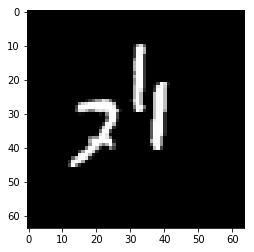

0 255


In [7]:

i = 1000
print(bds.image[i])
im_name = bds.resdir + 'images/'+ bds.image[i]['image']
color_name = bds.resdir + 'images/' + bds.image[i]['digit'][0]
print(im_name, color_name)
#print(os.path.exists('quick-netdissect/dataset/broden/broden1_227/images/'))
im = cv2.imread(im_name)

print(np.max(im))
#print(im)
plt.imshow(im)
plt.show()
color_im = cv2.imread(color_name)
print(np.min(color_im),np.max(color_im))


In [28]:
dissect('result/dissect', model, bds,
        recover_image=ReverseNormalize(IMAGE_MEAN, IMAGE_STDEV),
        batch_size=1,
        examples_per_unit=1)

we are startingg!
PROGRESS: method dissect, after loading device
PROGRESS: method dissect, after loading segloader
VERBOSE: segloader: <torch.utils.data.dataloader.DataLoader object at 0xb2f21f4e0>


(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 254 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
PROGRESS: method dissect, after collect_quantiles_and_topk
VERBOSE: levels: {'conv1': tensor([0.8338, 0.0000, 0.1443, 0.8594, 0.0682, 4.6029, 2.1728, 0.2823, 1.8454,
        0.3045, 1.5502, 2.4619, 0.9146, 1.0123, 1.8103, 0.0000, 0.2339, 3.9046,
        0.3461, 0.0000, 0.7421, 0.

VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 12
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 13
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 14
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 15
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 16
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 17
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 18
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 19
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 20
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 21
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 22
VERBOSE: row: tensor([0])
VERBOSE: rank: 0
VERBOSE: imgnum: 0
VERBOSE: unit: 23
VERBOSE: row: tensor([4])
VERBOSE: rank:

VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 52
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 53
VERBOSE: row: tensor([0])
VERBOSE: rank: 0
VERBOSE: imgnum: 0
VERBOSE: unit: 54
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 55
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 56
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 57
VERBOSE: row: tensor([0])
VERBOSE: rank: 0
VERBOSE: imgnum: 0
VERBOSE: unit: 58
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 59
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 60
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 61
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 62
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 63
VERBOSE: row: tensor([1])
VERBOSE: rank:

VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 68
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 69
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 70
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 71
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 72
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 73
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 74
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 75
VERBOSE: row: tensor([0])
VERBOSE: rank: 0
VERBOSE: imgnum: 0
VERBOSE: unit: 76
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 77
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 78
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 79
VERBOSE: row: tensor([5])
VERBOSE: rank:

VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 140
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 141
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 142
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 143
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 144
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 145
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 146
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 147
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 148
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 149
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 150
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 151
VERBOSE: row: tensor([5])
VE

VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 370
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 371
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 372
VERBOSE: row: tensor([0])
VERBOSE: rank: 0
VERBOSE: imgnum: 0
VERBOSE: unit: 373
VERBOSE: row: tensor([1])
VERBOSE: rank: 0
VERBOSE: imgnum: 1
VERBOSE: unit: 374
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 375
VERBOSE: row: tensor([5])
VERBOSE: rank: 0
VERBOSE: imgnum: 5
VERBOSE: unit: 376
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 377
VERBOSE: row: tensor([4])
VERBOSE: rank: 0
VERBOSE: imgnum: 4
VERBOSE: unit: 378
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 379
VERBOSE: row: tensor([3])
VERBOSE: rank: 0
VERBOSE: imgnum: 3
VERBOSE: unit: 380
VERBOSE: row: tensor([2])
VERBOSE: rank: 0
VERBOSE: imgnum: 2
VERBOSE: unit: 381
VERBOSE: row: tensor([3])
VE

(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 254 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
(64, 64, 3) 0 255 <class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 224, 224)
<class 'numpy.ndarray'> (3, 224, 224) (224, 224)
(3, 22

VERBOSE: make_labels: True


TypeError: list indices must be integers or slices, not numpy.float64